# Interactive viewing of LoDiS pressure calculations
#### Paul Guhennec, July 2019

This code reads movie.xyz and energy.out files to visualize the
pressure values computed via LoDiS.
Are produced:
- 1) 3D Plot of the molecule with the pressure as colour-code
- 2) Distribution of pressure values
- 3) Radial distribution of pressures
- 4) Energy and pressure evolution depending on time (frame #)

1, 2, and 3 are produced for each frame of the movie.xyz file.

More details are given in the corresponding script .py file.

In [47]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib
from mpl_toolkits.mplot3d import Axes3D
from itertools import groupby
#For interactive viewing
%matplotlib inline 

In [92]:
# VARIABLES TO PARAMTERISE
MOVIE_TO_ANALYSE = './Pressure_Ag_316_M/movie.xyz' #Path to movie file (as .xyz or any other data text format)
ENERGY_TO_ANALYSE = './Pressure_Ag_316_M/energy.out' #Path to energy file (.out)
BASE_FIG_PATHS = './Pressure_Ag_316_M/Results/' #Path to folder where figures are to be stored

# Setting the limits of the colour-map for 3D plot.
# These limits are common to all frame plots, hence allow comparaison.
# Set to None for automatic rescaling.
PRES_MIN = -15
PRES_MAX = 15

# Setting the limits of the axis for 3D plot.
# Similarly, common to all plots: movement between frames better identified.
# Cannot be set to None.
X_AXIS_MIN = -18
X_AXIS_MAX = 18
Y_AXIS_MIN = -18
Y_AXIS_MAX = 18
Z_AXIS_MIN = -18
Z_AXIS_MAX = 18

if not os.path.isdir(BASE_FIG_PATHS): #Creates the directory to store results
    os.mkdir(BASE_FIG_PATHS)

# Analysis subroutines

In [82]:
def plotMoleculePressure(x_s, y_s, z_s, pressure_values, title='LoDiS Pressure Map', file_name=''):
    """
    Plot a 3D pressure map from input x, y, z, P.
    
    Input:
        x_s: array of x coords
        y_s: array of y coords
        z_s: array of z coords
        pressure_values: pressure
        title: figure title
        file_name: saved fig name
    """
    
    fig = plt.figure(title)
    ax = fig.add_subplot(111, projection='3d')
    plt.title(title)
    #plt.legend()
    ax.set_xlim3d(X_AXIS_MIN, X_AXIS_MAX)
    ax.set_ylim3d(Y_AXIS_MIN, Y_AXIS_MAX)
    ax.set_zlim3d(Z_AXIS_MIN, Z_AXIS_MAX)
    
    im = ax.scatter(x_s, y_s, z_s, c=pressure_values,\
                    s=100, cmap='jet', vmin=PRES_MIN, vmax=PRES_MAX)
    fig.colorbar(im)
    plt.savefig(BASE_FIG_PATHS+'Molecule'+str(file_name))
    plt.show()
    
    
def plotPressureHistogram(data, bins=50, fig_title='Pressure_Histogram', file_name=''):
    """
    Takes a set of pressure values, and plots a normalized
    and colour-coded histogram of them.
    
    Input:
        data: array of floats
        bins: number of histogram bins (default: 50)
        fig_title: label of pyplot figure
        file_name: saved figure name
    """
    # need to try to use https://stackoverflow.com/questions/24621197/matplotlib-colorbar-with-a-histogram
    # to make cmap between VMIN and VMAX
    
    cm = plt.cm.get_cmap('jet')
    # Plot histogram.
    n, bins, patches = plt.hist(data, 50, density=1, color='green')
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.title(fig_title)
    plt.xlabel('Atomic pressure [GPa]')
    plt.ylabel('Normalized count [ ]')
    plt.savefig(BASE_FIG_PATHS+'Histogram'+str(file_name))

    plt.show()

In [83]:
def readMovieFile(path_to_movie):
    """
    Reads a LoDiS movie.xyz file and fetches the coordinates and pressures
    for each atom for each frame.
    
    Input:
        path_to_movie: path to movie.xyz
    
    Returns:
        {x,y,z,p}_at_frames: list (each frame) of list (each atom) of floats for the position and pressure
    """
    
    read_file_chars = []

    with open(path_to_movie, 'r') as file:
        for line in file:
            read_file_chars.append(line)
    # 1. Delete line jump
    read_file_chars = [line[:-1] for line in read_file_chars]
    read_file_chars

    # 2. Separate line by line
    grouped_lines = [([list(group) for k, group in\
              groupby(line,lambda x: x == " ")\
              if not k]) for line in read_file_chars]

    # 3. Concatenate charaters
    joined_string = [[''.join(info_elem) for info_elem in grouped_line] for grouped_line in grouped_lines]

    # 4. Regroup into list of lists. Elements of outerlist are movie frames
    merged_frames = []
    current_frame = []

    for line in joined_string:
        if(line==joined_string[0]):

            if len(current_frame)!=0:
                merged_frames.append(current_frame)
            current_frame=[]
        else:
            current_frame.append(line)
    merged_frames.append(current_frame)

    # 5. Removing second line of header
    merged_frames = [frame[1:] for frame in merged_frames]

    # 6. Converting coordinates and pressure to floats
    for frame in merged_frames:
        for line in frame:
            line[1] = float(line[1]) # x coord
            line[2] = float(line[2]) # y coord
            line[3] = float(line[3]) # z coord
            line[5] = float(line[5]) # pressure

    # 7. Storing x, y, z, p in dedicated arrays
    x_at_frames = [[line[1] for line in frame] for frame in merged_frames]
    y_at_frames = [[line[2] for line in frame] for frame in merged_frames]
    z_at_frames = [[line[3] for line in frame] for frame in merged_frames]

    p_at_frames = [[line[5] for line in frame] for frame in merged_frames]
    
    return([x_at_frames, y_at_frames, z_at_frames, p_at_frames])

In [84]:
def readEnergyFile(path_to_energy):
    """
    Reads the energy.out file.
    
    Input:
        path_to_energy: path to energy.out
    
    Returns:
        total_energies: array of Etot, one per frame
        temperatures: array of temperatures, one per frame
    """
    
    read_file_chars = []

    with open(path_to_energy, 'r') as file:
        for line in file:
            read_file_chars.append(line)
            
    # 1. Delete line jump
    read_file_chars = [line[:-1] for line in read_file_chars]
    read_file_chars

    # 2. Separate line by line
    grouped_lines = [([list(group) for k, group in\
              groupby(line,lambda x: x == " ")\
              if not k]) for line in read_file_chars]

    # 3. Concatenate charaters and remove header
    joined_string = [[''.join(info_elem) for info_elem in grouped_line] for grouped_line in grouped_lines]
    joined_string.pop(0)
    
    # 4. Regroup into list of lists. Elements of outerlist are movie frames
    total_energies = []
    temperatures = []
    
    for line in joined_string:
        total_energies.append(float(line[2]))
        temperatures.append(float(line[6]))
    return([total_energies, temperatures])

In [85]:
def plotRadialPressure(x_s, y_s, z_s, pressure_values, figtitle='LoDiS Pressure Radial Relationship', filename=''):
    """
    Plots the average pressure depending on radial distance.
    
    Input:
        x_s: array of x coords
        y_s: array of y coords
        z_s: array of z coords
        pressure_values: pressure
        figtitle: figure title
        filename: name of exported png
    """
    radial_distances = []
    mean_x, mean_y, mean_z = np.mean(x_s), np.mean(y_s), np.mean(z_s) # Centre of mass coords
    
    for i in range(len(x_s)):
        try:
            radial_distances.append(np.sqrt((x_s[i]-mean_x)**2+(y_s[i]-mean_y)**2+(z_s[i]-mean_z)**2))
        except AttributeError:
            print('r')
            print(x_s)
        
    
    plt.figure(figtitle)
    plt.title(figtitle)
    plt.xlabel('Distance from centre [A]')
    plt.ylabel('Atomic pressure [GPa]')
    plt.scatter(radial_distances, pressure_values)

    plt.savefig(BASE_FIG_PATHS+'RadialPressure'+str(filename))
    plt.show()

## Results

### 1. Molecule geometry

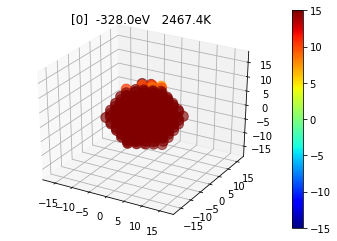

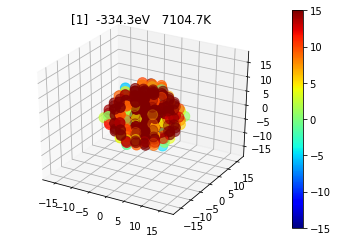

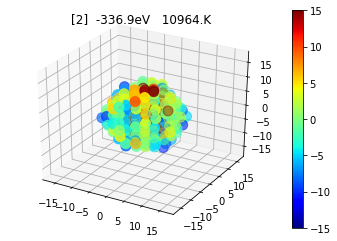

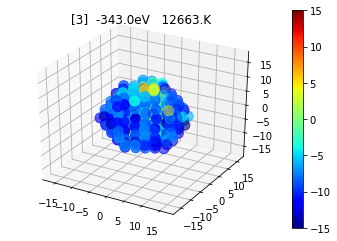

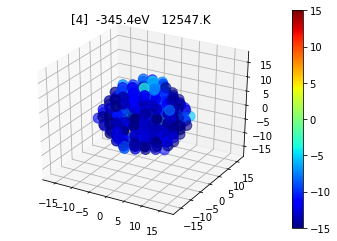

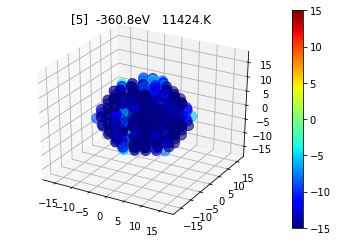

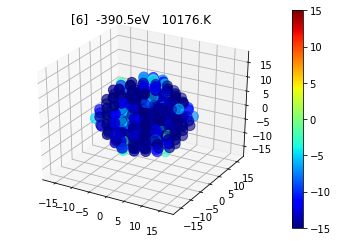

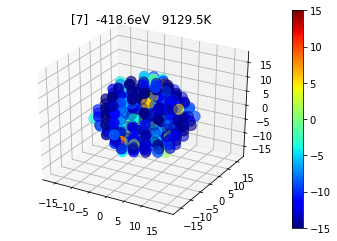

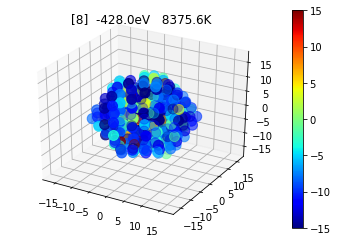

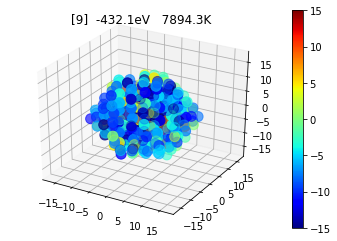

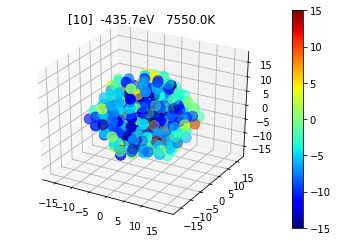

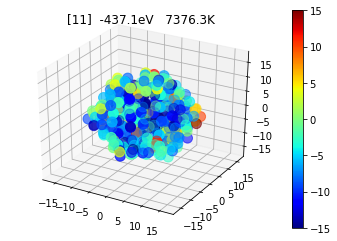

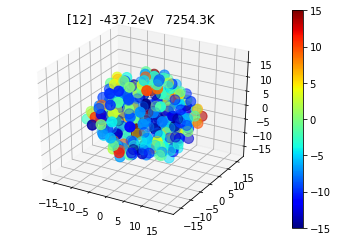

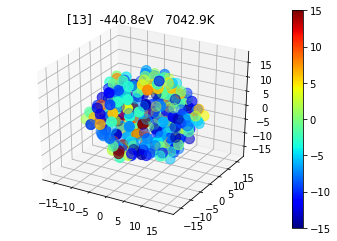

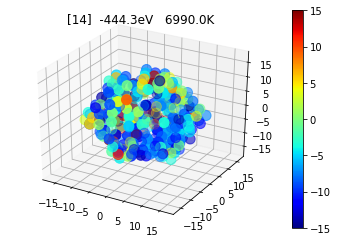

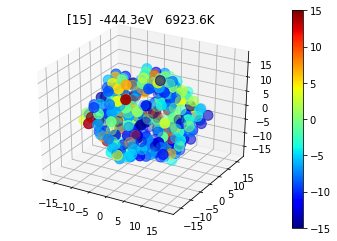

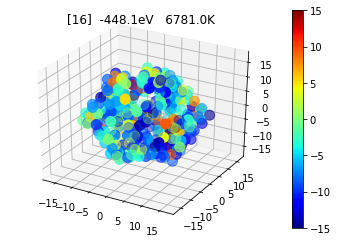

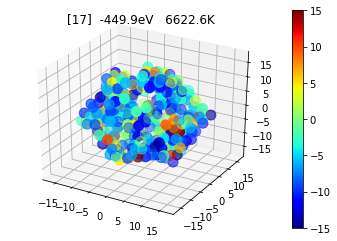

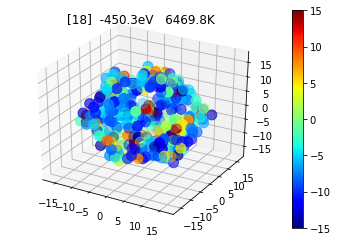

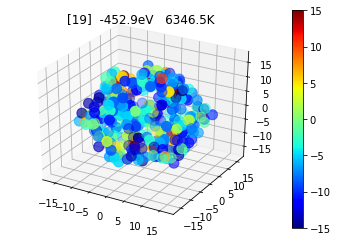

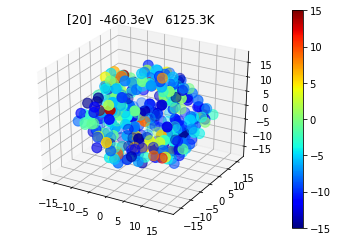

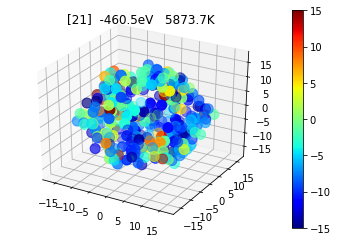

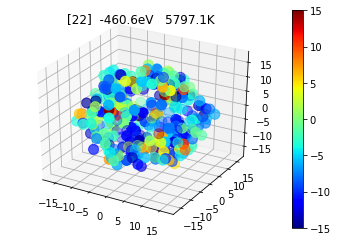

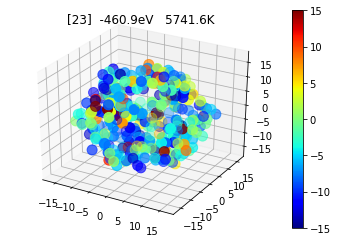

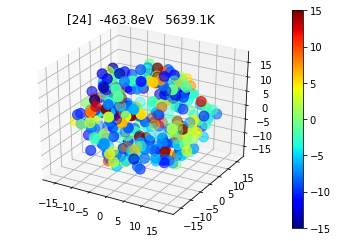

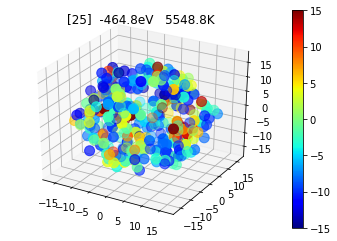

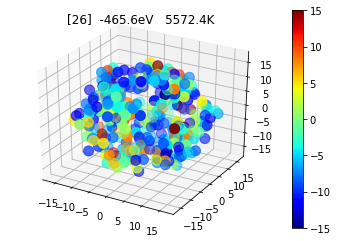

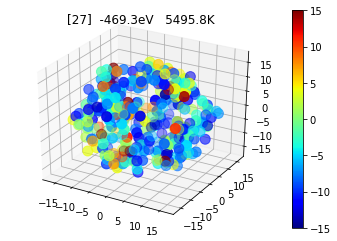

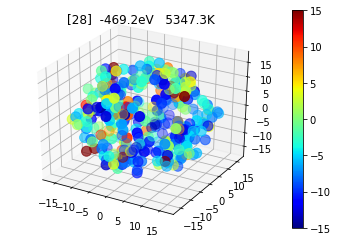

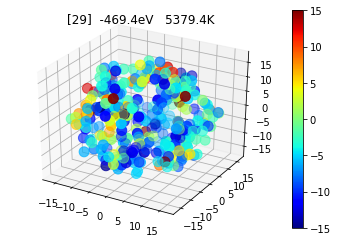

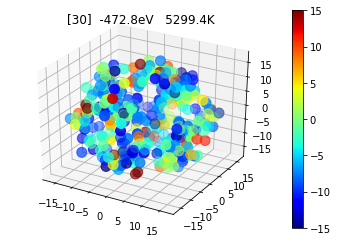

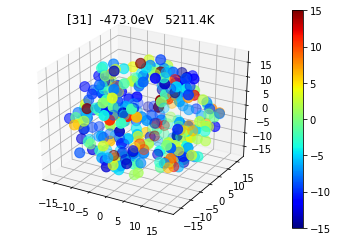

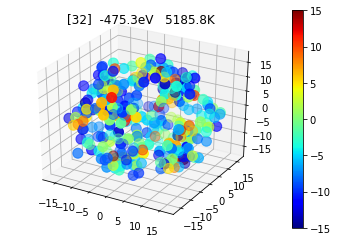

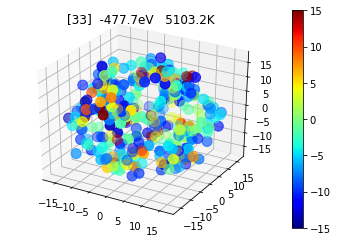

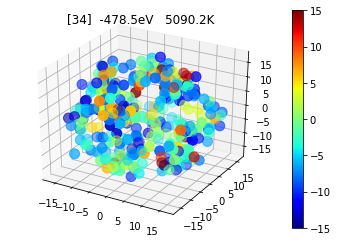

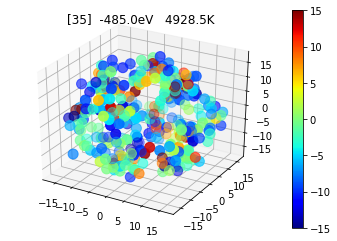

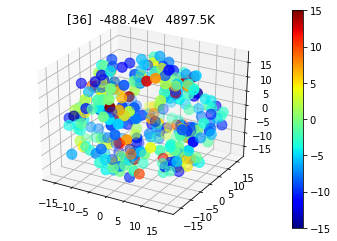

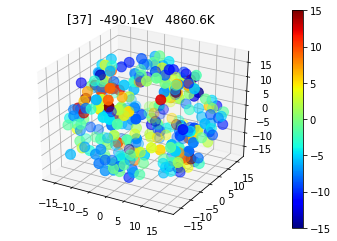

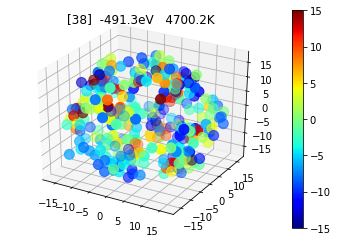

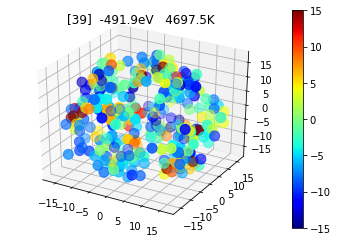

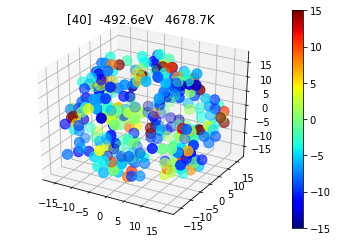

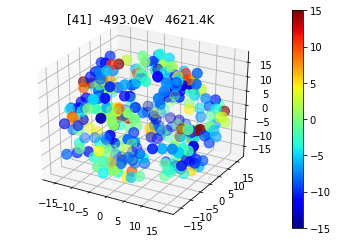

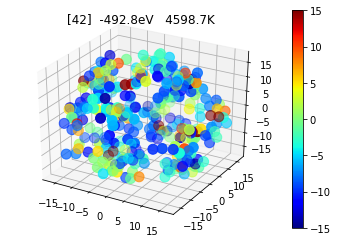

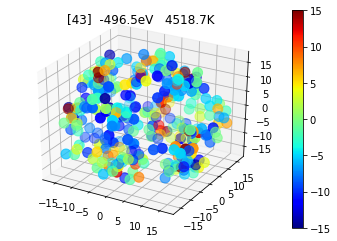

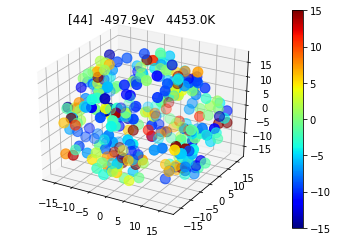

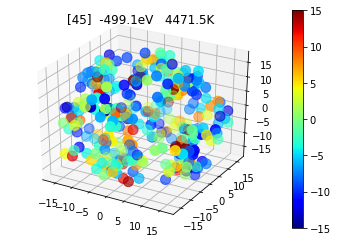

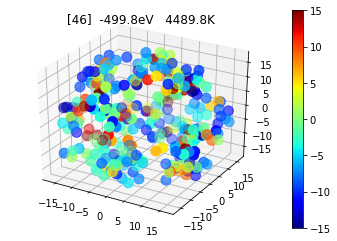

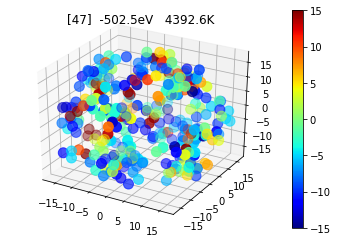

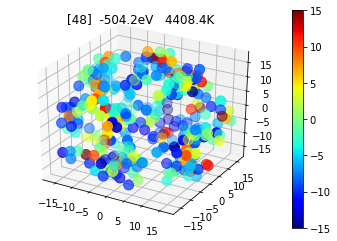

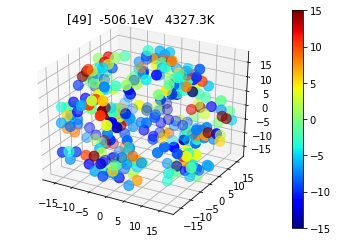

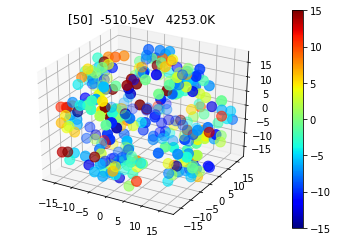

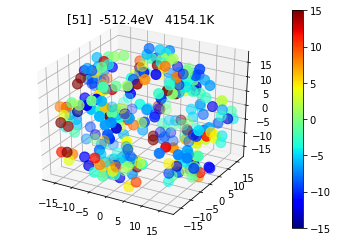

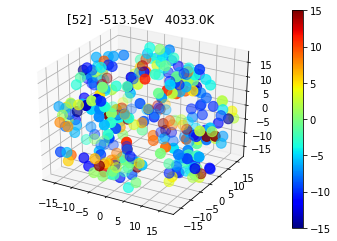

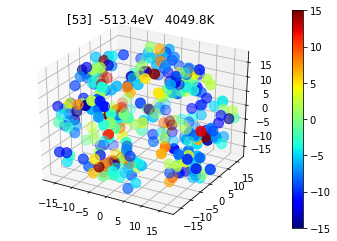

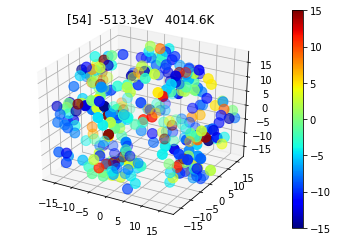

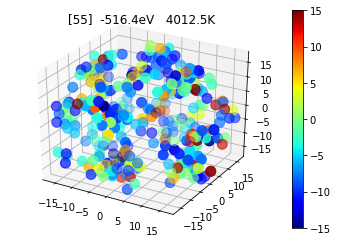

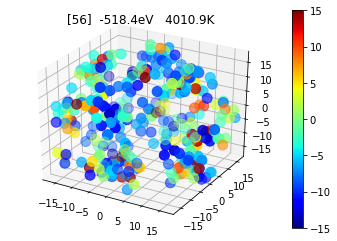

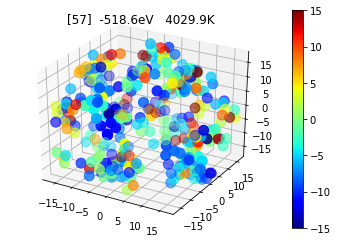

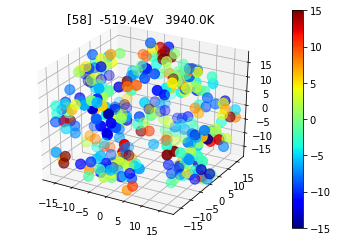

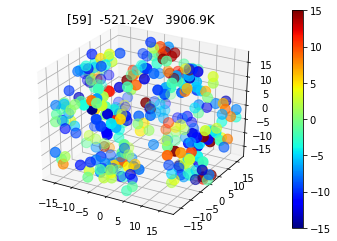

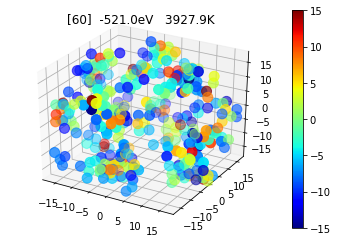

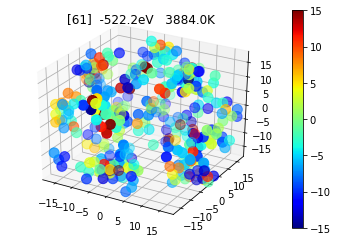

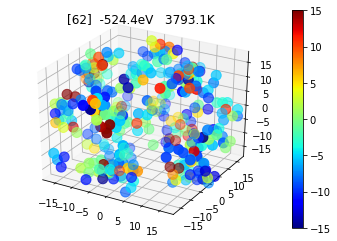

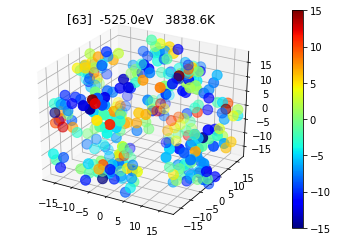

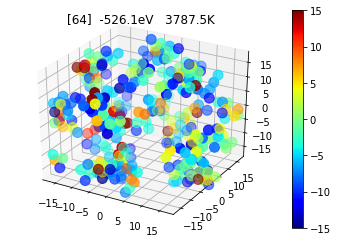

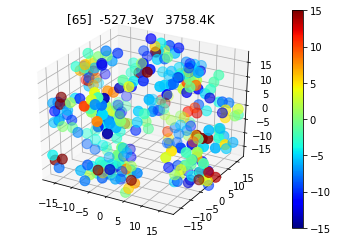

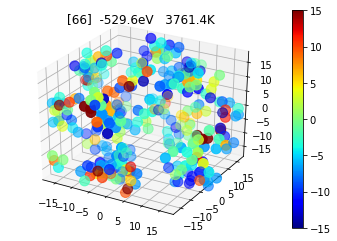

In [93]:
energies, temperatures = readEnergyFile(ENERGY_TO_ANALYSE)

tuple_from_movie = readMovieFile(MOVIE_TO_ANALYSE)
for frame_num, _ in enumerate(tuple_from_movie[0]):    
    plotMoleculePressure(tuple_from_movie[0][frame_num], tuple_from_movie[1][frame_num],\
                         tuple_from_movie[2][frame_num],tuple_from_movie[3][frame_num],\
                         title='[{}]  {}eV   {}K'.format(frame_num, str(energies[frame_num])[:6],\
                                                           str(temperatures[frame_num])[:6]),\
                        file_name=str(frame_num))


### 2. Pressure distribution

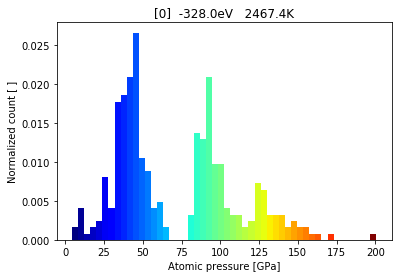

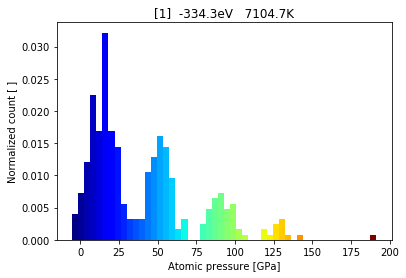

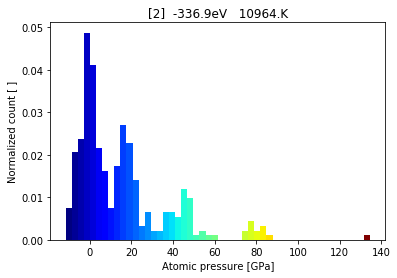

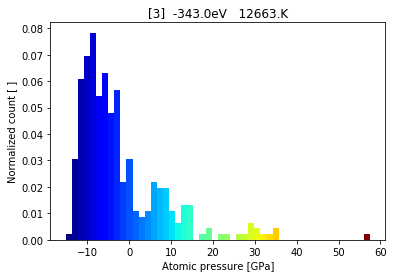

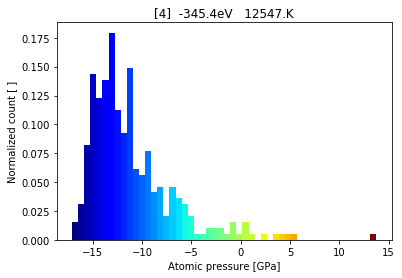

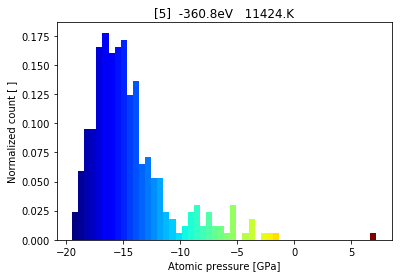

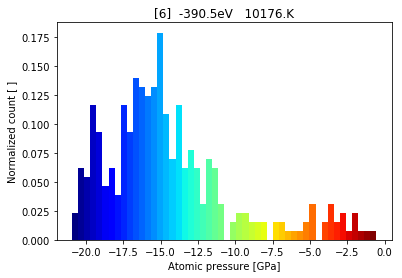

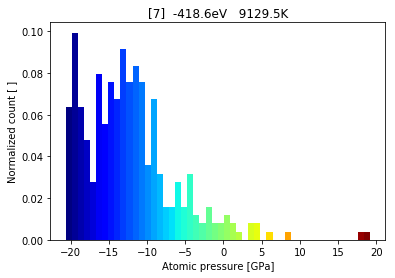

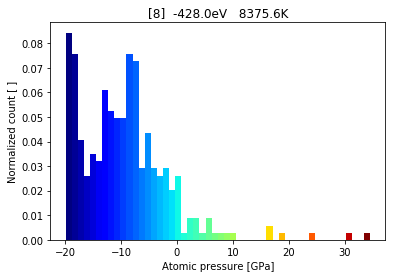

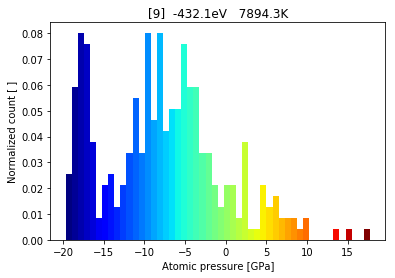

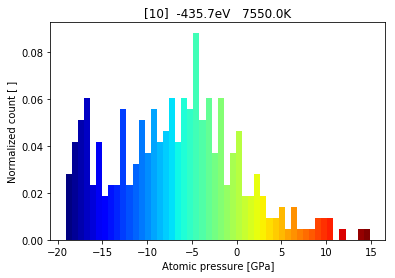

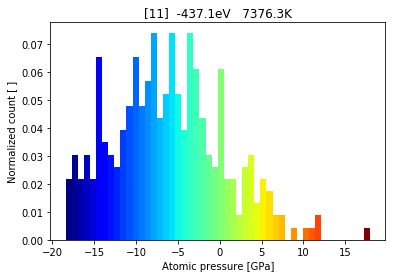

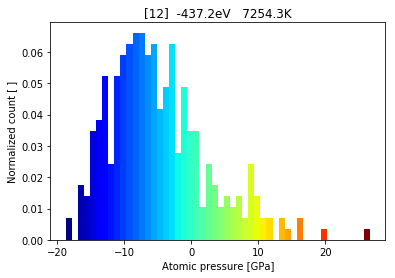

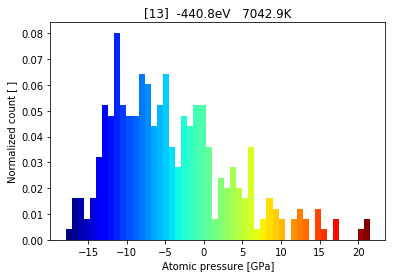

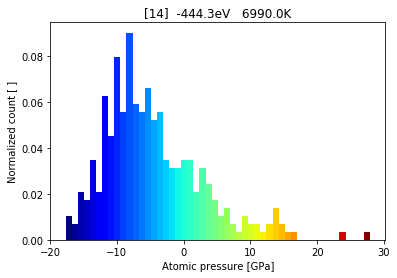

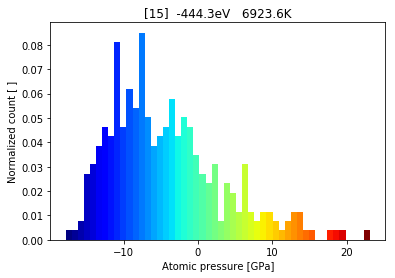

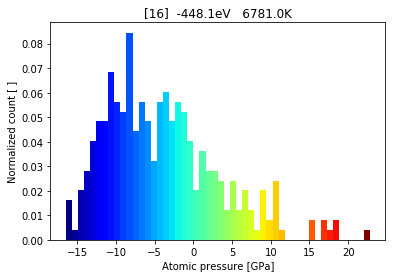

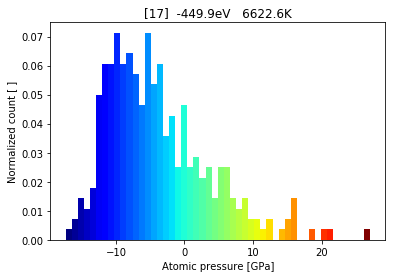

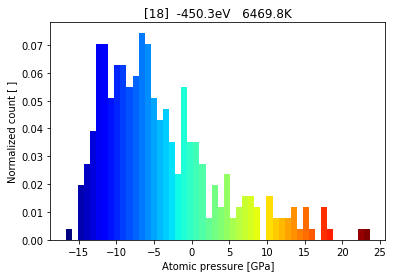

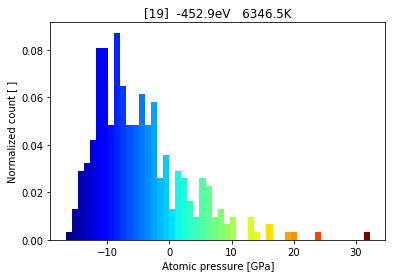

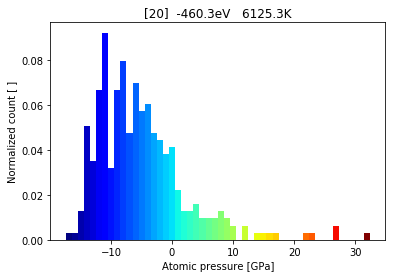

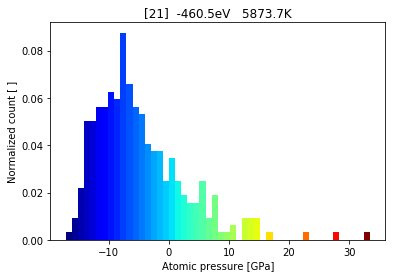

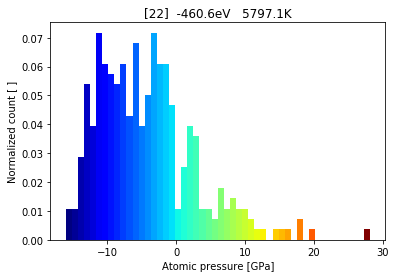

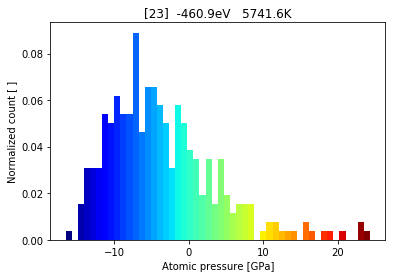

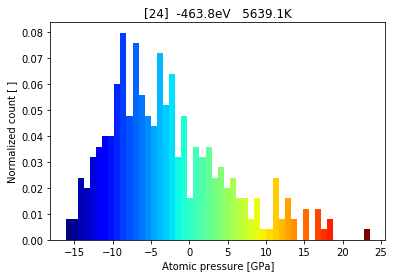

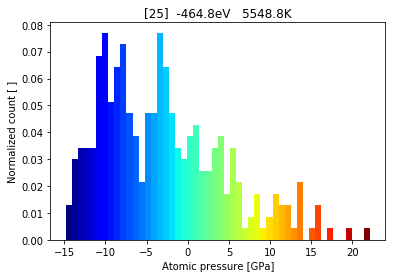

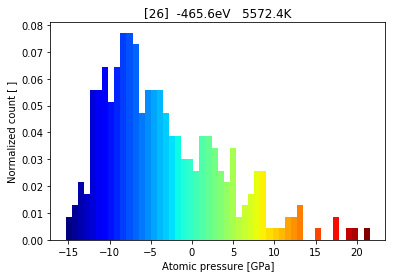

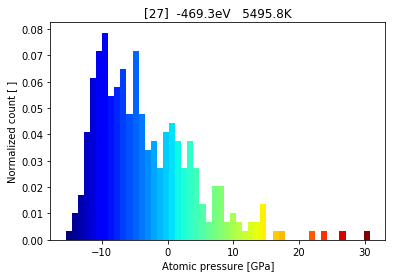

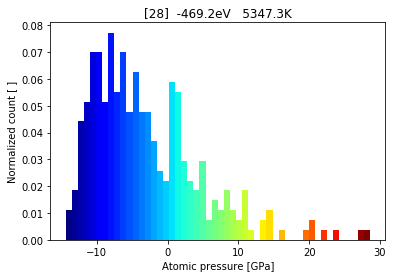

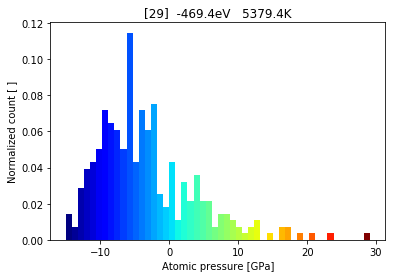

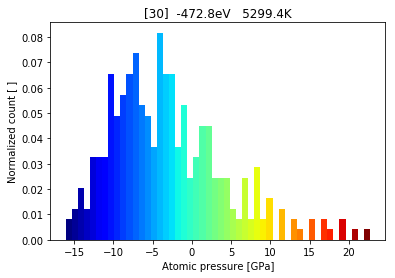

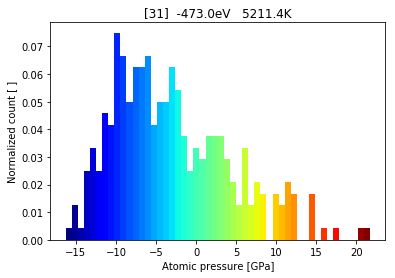

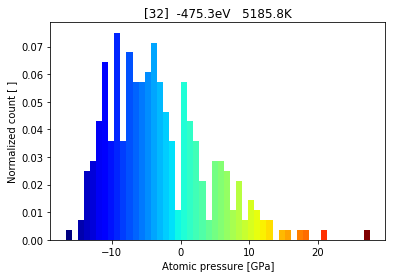

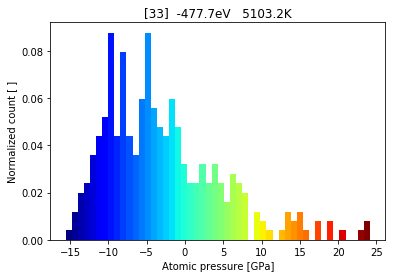

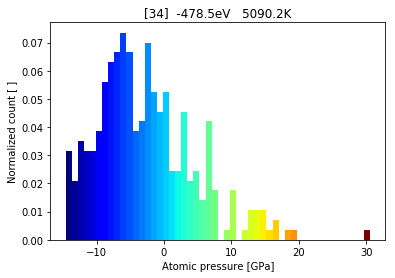

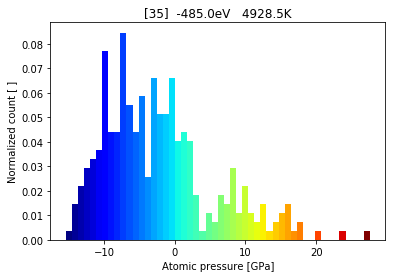

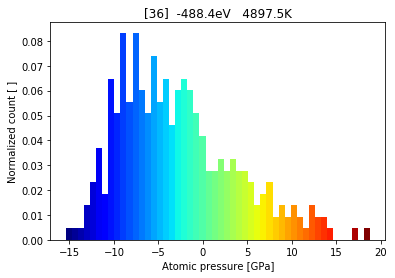

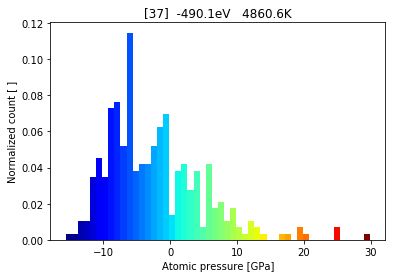

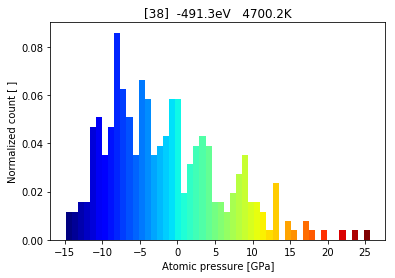

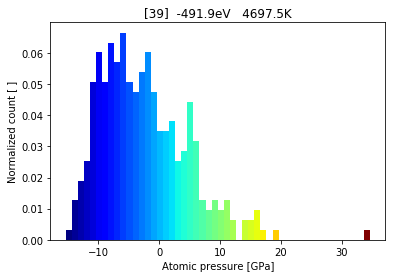

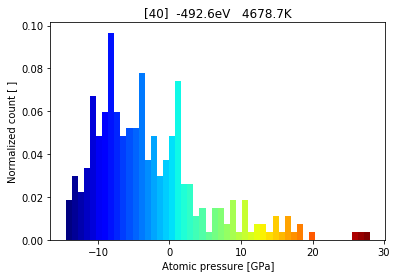

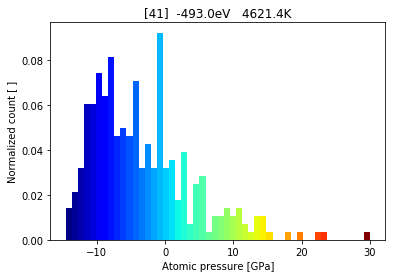

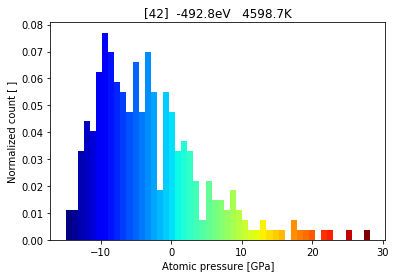

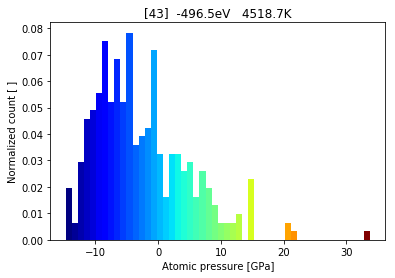

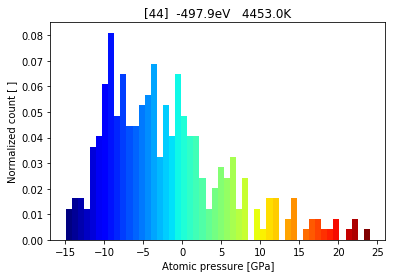

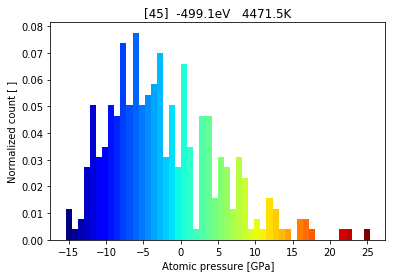

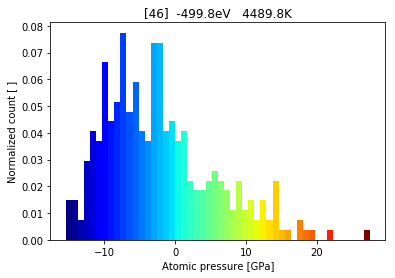

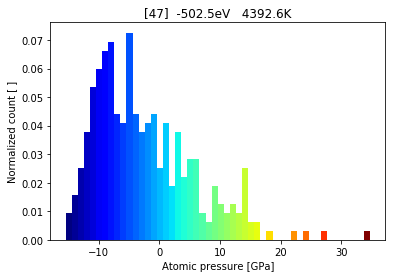

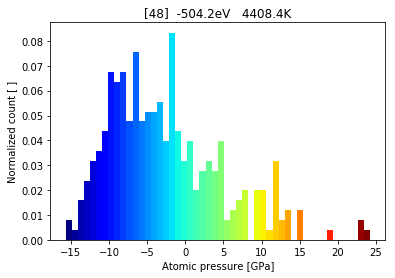

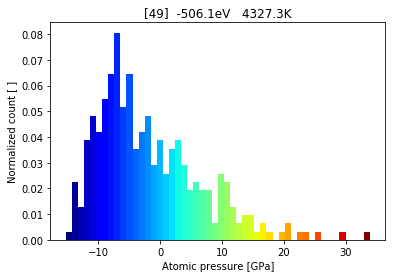

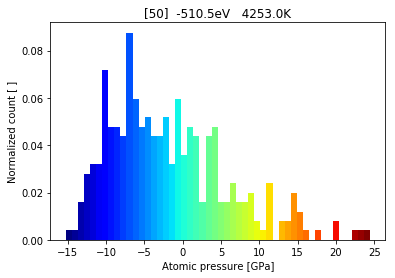

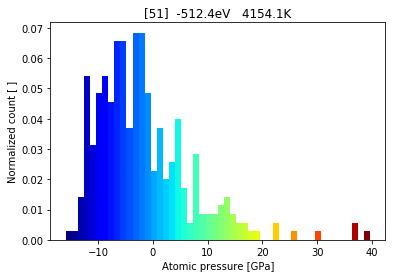

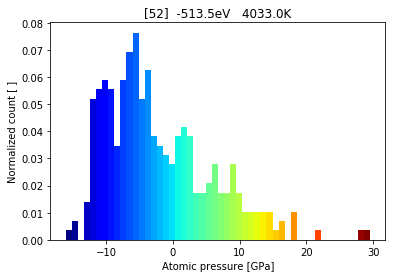

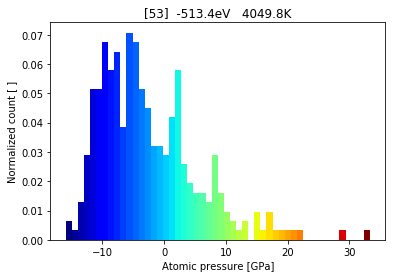

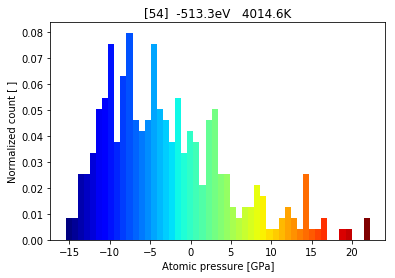

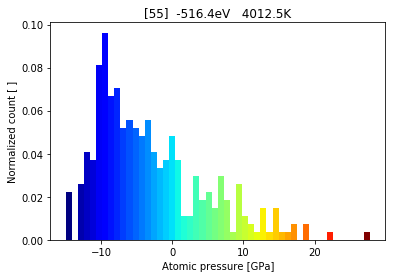

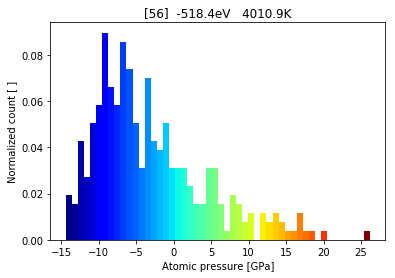

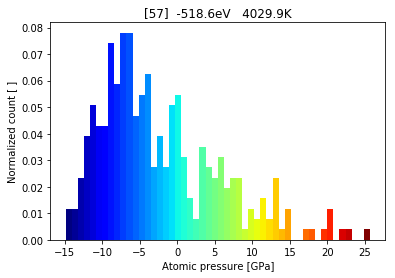

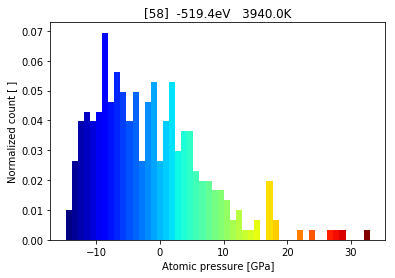

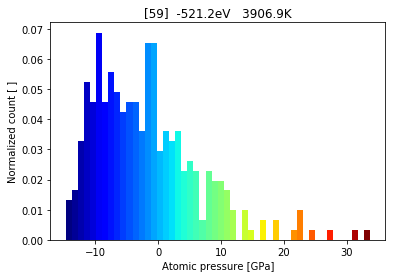

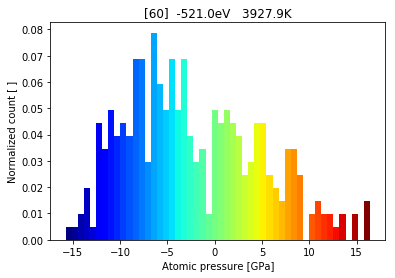

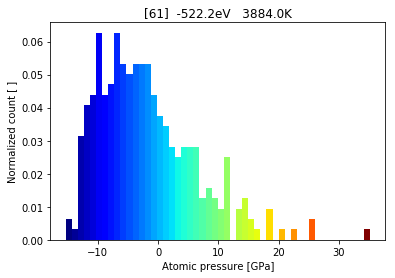

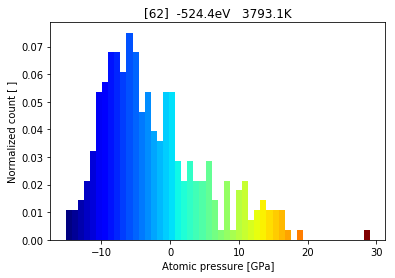

/home/k1501798/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/k1501798/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


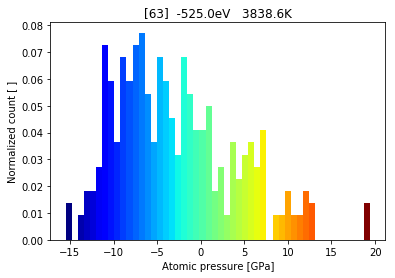

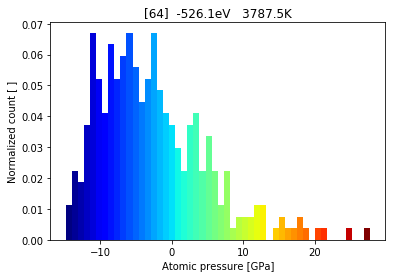

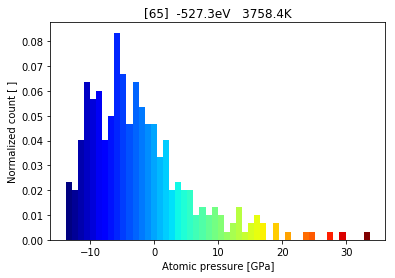

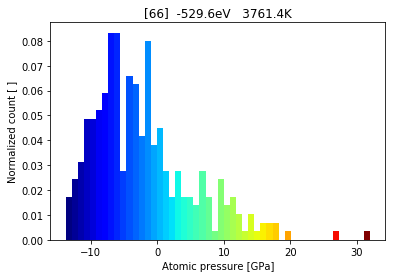

In [87]:
energies, temperatures = readEnergyFile(ENERGY_TO_ANALYSE)

for frame_num, frame_values in enumerate(readMovieFile(MOVIE_TO_ANALYSE)[3]):
    plotPressureHistogram(frame_values,fig_title='[{}]  {}eV   {}K'.format(frame_num, str(energies[frame_num])[:6],\
                                                           str(temperatures[frame_num])[:6]),\
                         file_name=str(frame_num))

### 3. Pressure vs Radial distance

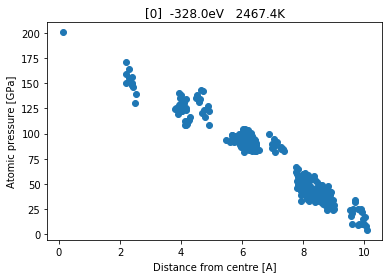

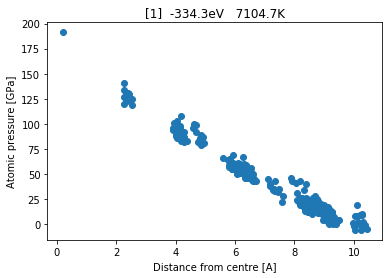

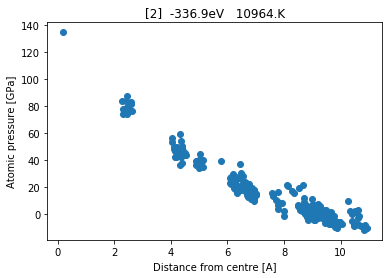

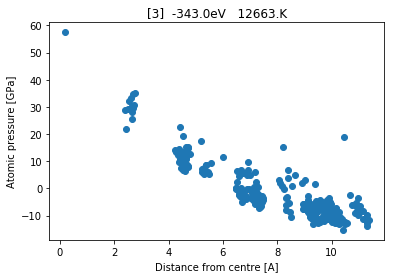

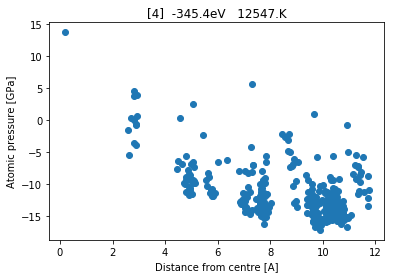

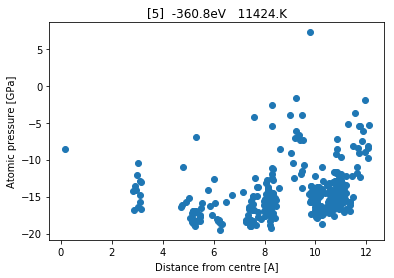

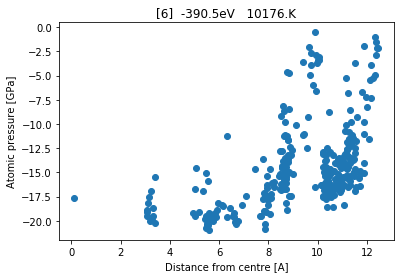

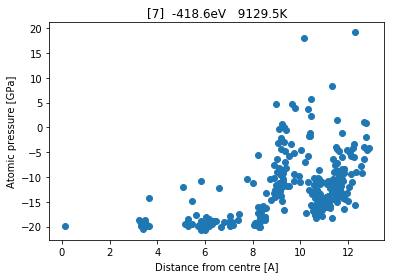

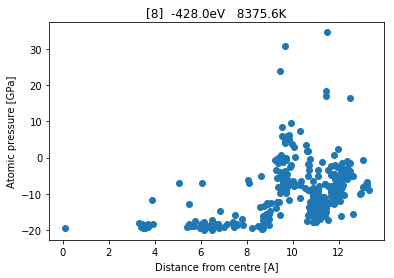

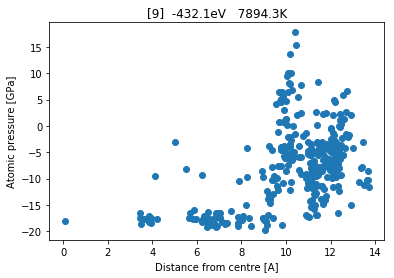

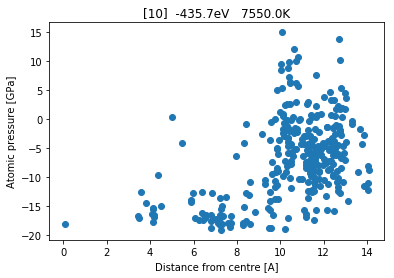

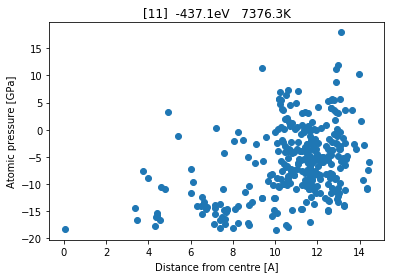

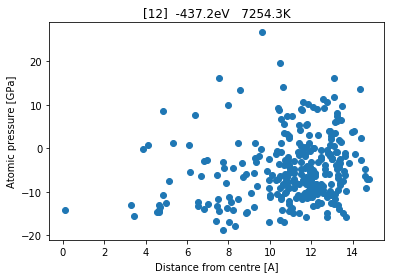

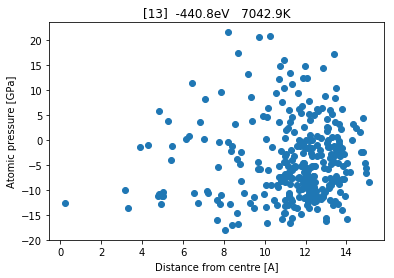

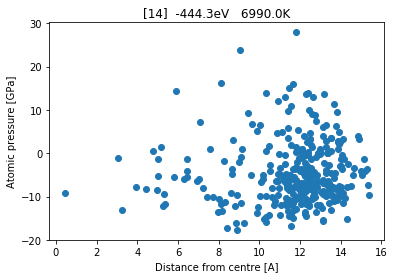

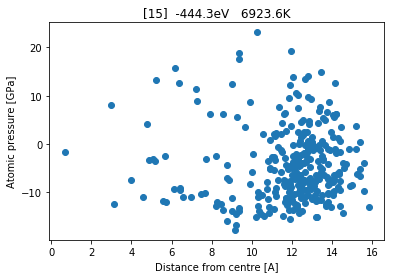

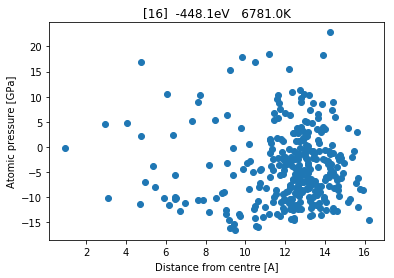

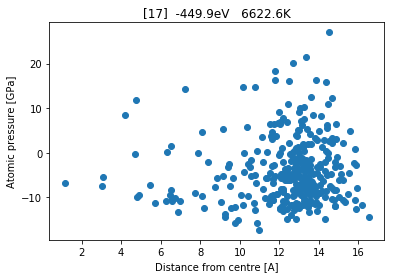

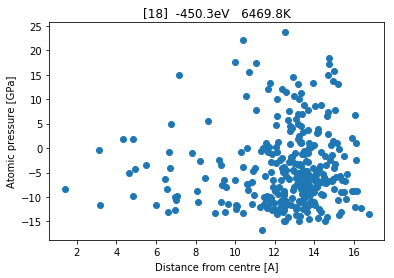

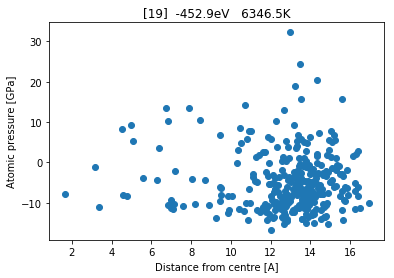

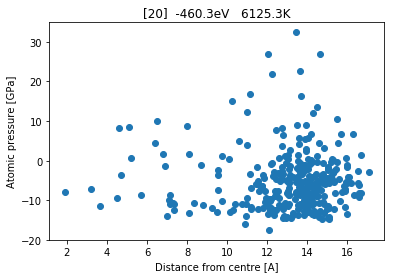

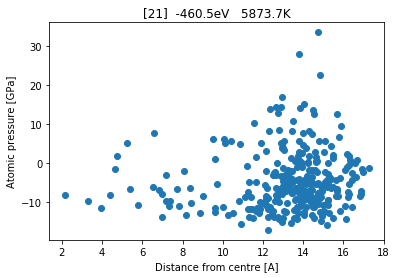

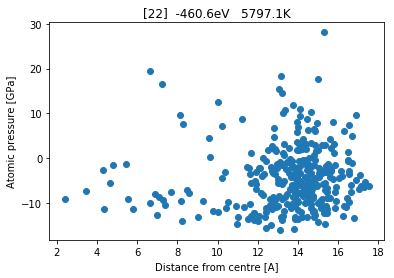

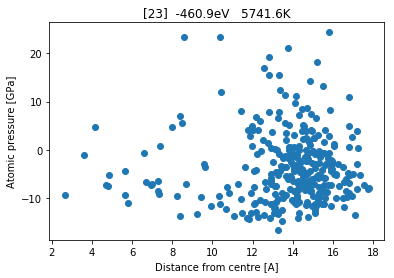

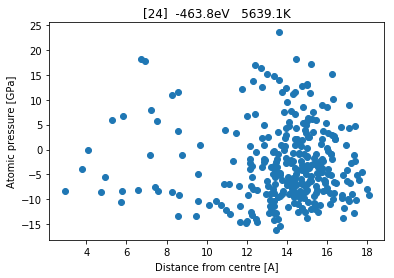

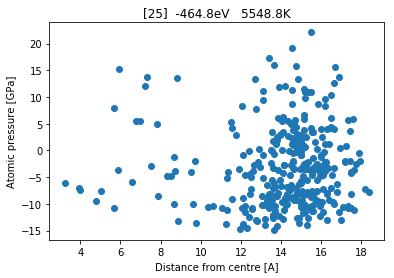

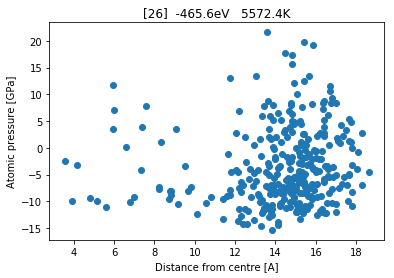

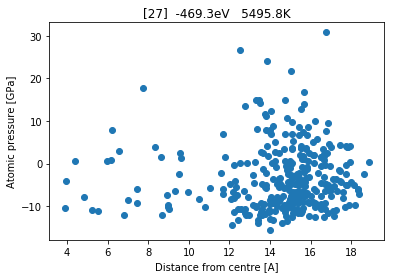

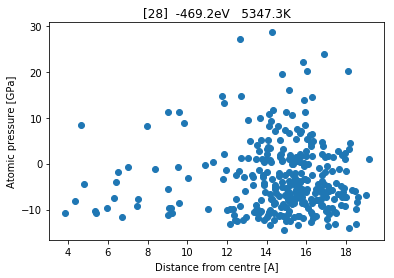

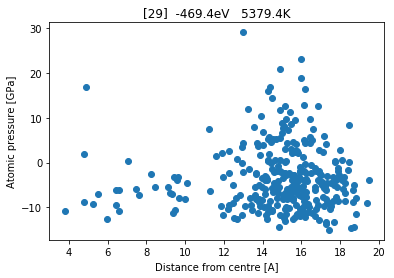

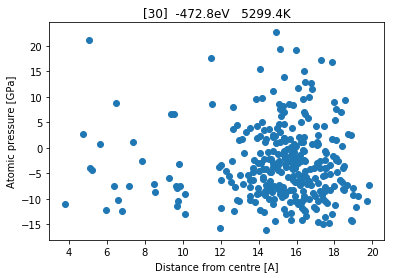

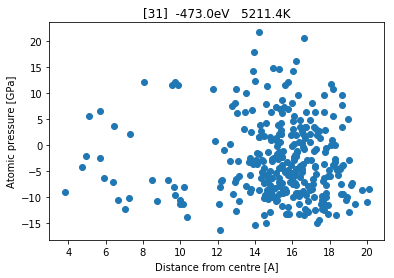

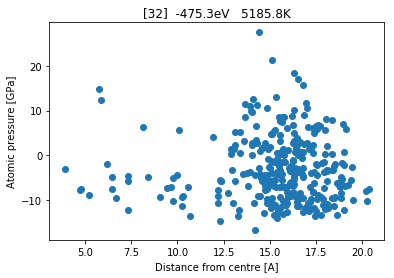

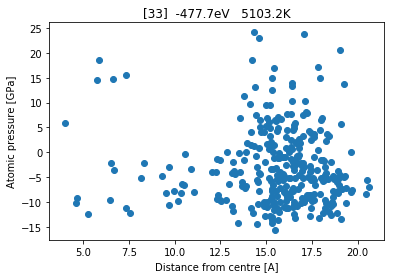

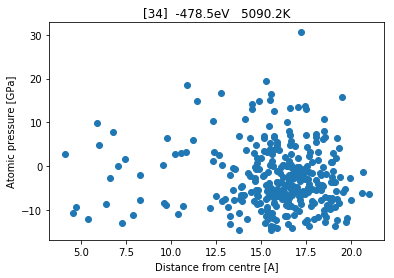

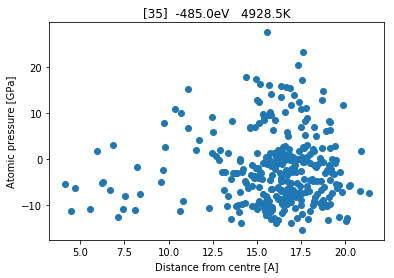

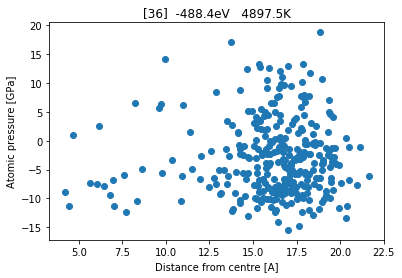

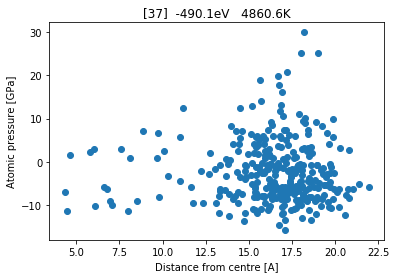

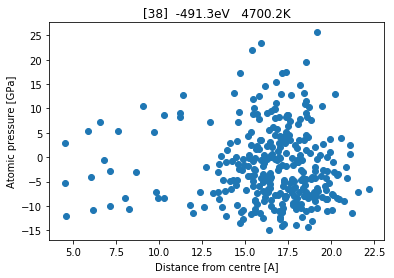

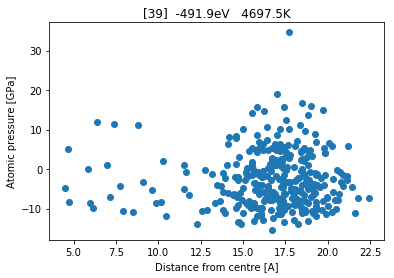

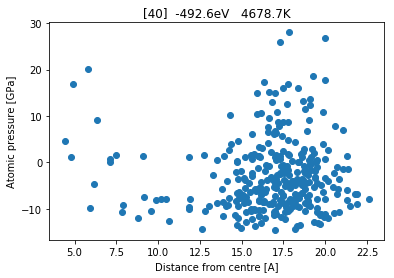

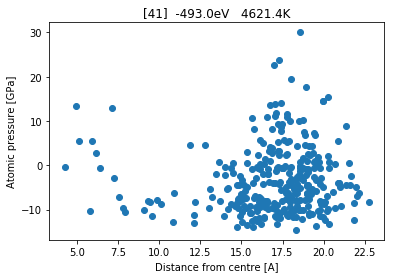

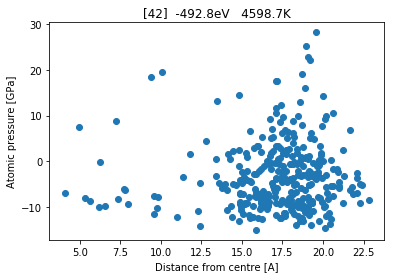

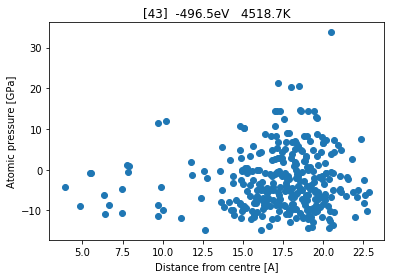

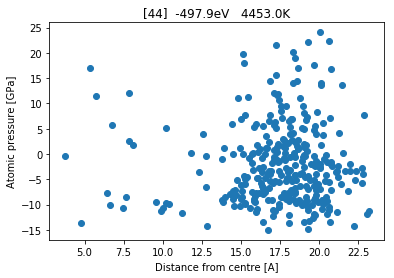

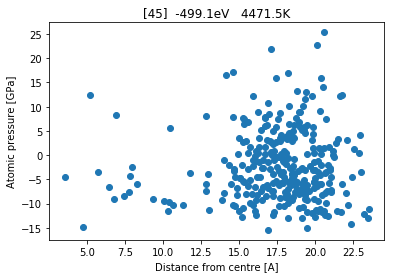

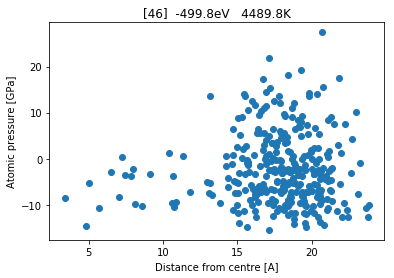

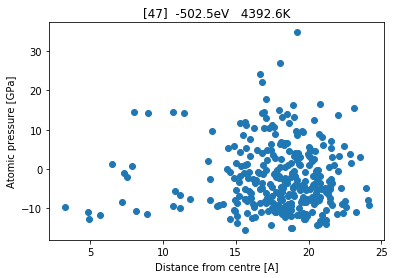

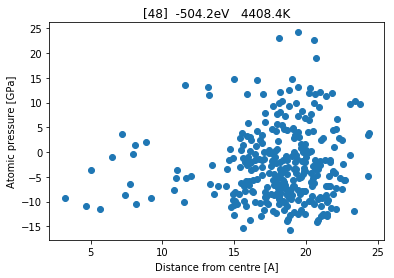

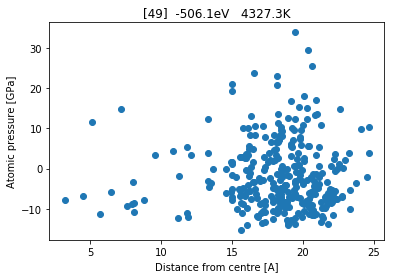

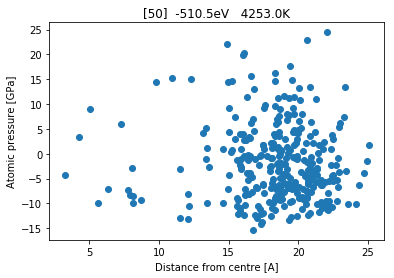

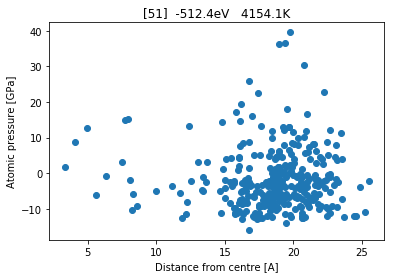

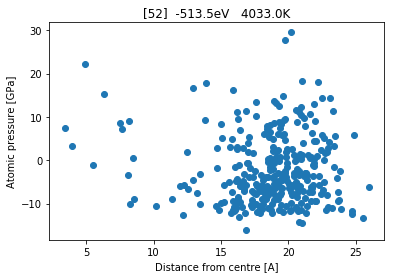

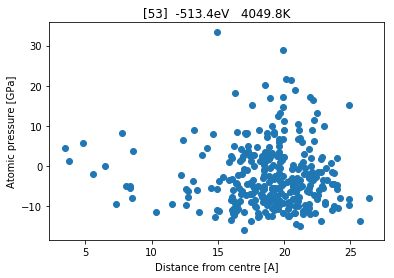

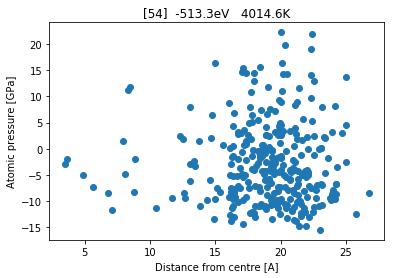

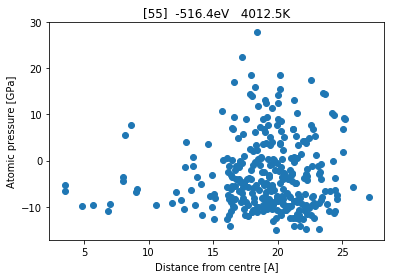

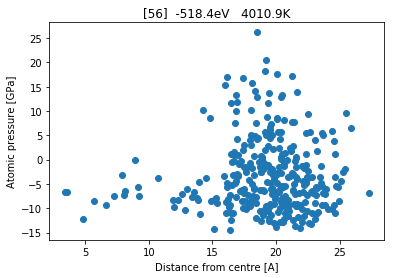

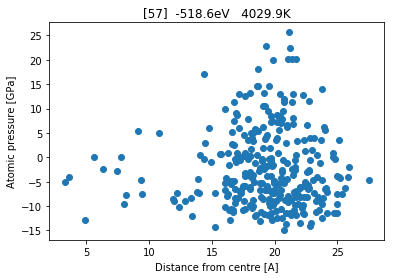

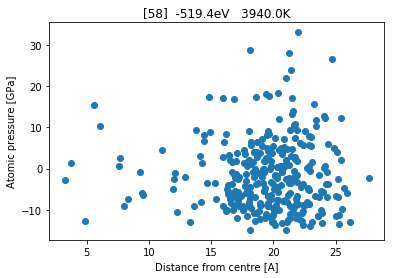

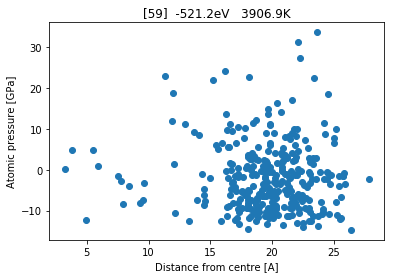

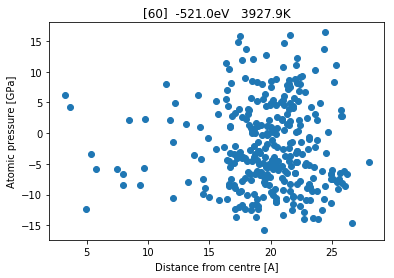

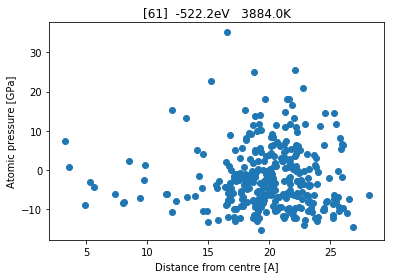

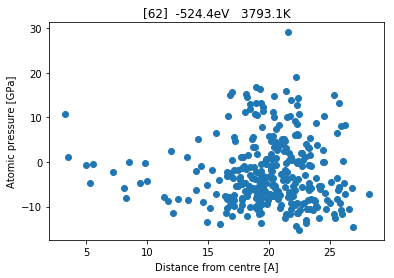

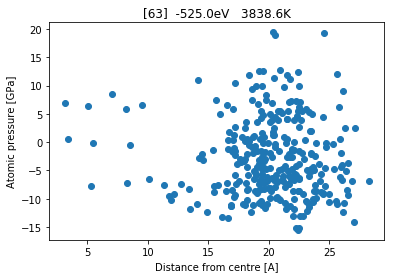

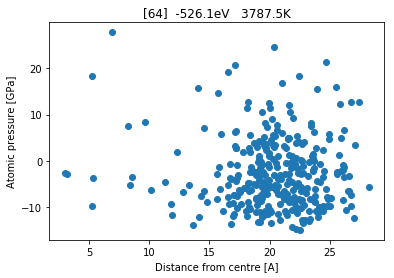

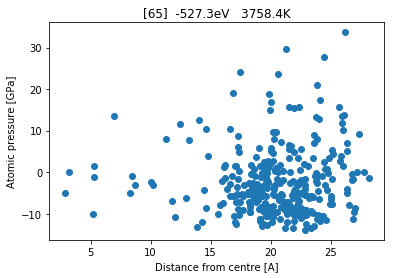

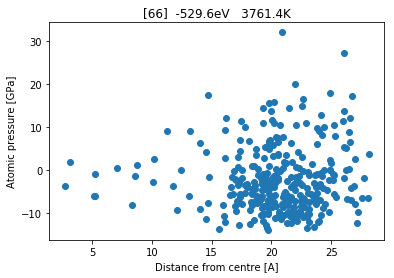

In [88]:
energies, temperatures = readEnergyFile(ENERGY_TO_ANALYSE)

tuple_from_movie = readMovieFile(MOVIE_TO_ANALYSE)
for frame_num, _ in enumerate(tuple_from_movie[0]):    
    plotRadialPressure(tuple_from_movie[0][frame_num], tuple_from_movie[1][frame_num],\
                         tuple_from_movie[2][frame_num],tuple_from_movie[3][frame_num],\
                       figtitle ='[{}]  {}eV   {}K'.format(frame_num, str(energies[frame_num])[:6],\
                                                           str(temperatures[frame_num])[:6]),\
                       filename = str(frame_num))


### 4. Pressure evolution

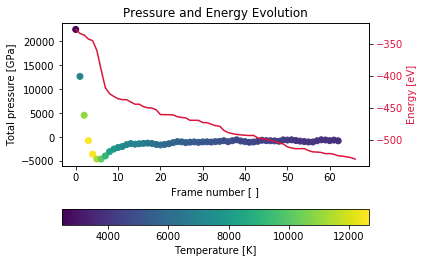

In [89]:
energies, temperatures = readEnergyFile(ENERGY_TO_ANALYSE)

pressure_evol = []

for frame_num, frame_values in enumerate(readMovieFile(MOVIE_TO_ANALYSE)[3]):
    pressure_evol.append(sum(frame_values))

fig, ax1 = plt.subplots()
plt.title('Pressure and Energy Evolution')

ax1.set_xlabel('Frame number [ ]')
ax1.set_ylabel('Total pressure [GPa]', color='black')
sc = ax1.scatter(range(len(pressure_evol)), pressure_evol, c=temperatures)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'crimson'
ax2.set_ylabel('Energy [eV]', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(pressure_evol)), energies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', pad=0.2)
cbar.set_label('Temperature [K]')
plt.savefig(BASE_FIG_PATHS+'EvolutionPressureEnergy')
plt.show()